In [47]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster import cluster_visualizer, cluster_visualizer_multidim
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from scipy import stats
import operator
import bisect

In [48]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, 
                 sep=',', index_col=0)
pd.set_option('display.max_columns', None) # to visualize all the columns
df.head()

,name,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,hand,gender,ioc,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
0,AARON ADDISON,0.181818,10.0,0.200000,1.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,14.98,0.587855,83.0,12.32,47.78,8.82,5.88,75.79
1,ABBIE MYERS,0.477707,142.0,0.478873,15.0,0.466667,R,F,AUS,1994.0,170.857143,61.621951,1.30,0.279256,819.0,4.67,22.10,3.18,5.39,39.67
2,ABHINAV SANJEEV SHANMUGAM,0.500000,13.0,0.461538,3.0,0.666667,U,M,IND,1998.0,183.800000,86.875000,20.59,0.613701,111.0,10.89,51.65,7.12,10.10,70.86
4,ABIGAIL TERE APISAH,0.588710,111.0,0.576577,13.0,0.692308,U,F,PNG,1992.0,172.137193,62.577626,3.37,0.591260,1055.0,11.18,54.40,3.83,7.73,52.62
5,ABIR EL FAHIMI,0.153846,13.0,0.153846,0.0,0.000000,U,F,MAR,1995.0,172.137193,59.409091,0.00,0.189542,110.0,16.30,17.20,0.51,2.55,11.88


In [49]:
cat_feature = df[['name', 'hand', 'gender', 'ioc']]
cat_feature

,name,hand,gender,ioc
0,AARON ADDISON,R,M,AUS
1,ABBIE MYERS,R,F,AUS
2,ABHINAV SANJEEV SHANMUGAM,U,M,IND
4,ABIGAIL TERE APISAH,U,F,PNG
5,ABIR EL FAHIMI,U,F,MAR
...,...,...,...,...
3871,ZIZOU BERGS,R,M,BEL
3876,ZOE HIVES,U,F,AUS
3878,ZOE KRUGER,U,F,RSA
3884,ZSOMBOR PIROS,R,M,HUN


In [50]:
num_features = df
del num_features['name']
del num_features['gender']
del num_features['ioc']
del num_features['hand']
 
num_features

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
0,0.181818,10.0,0.200000,1.0,0.000000,1996.0,187.076923,86.694444,14.98,0.587855,83.0,12.32,47.78,8.82,5.88,75.79
1,0.477707,142.0,0.478873,15.0,0.466667,1994.0,170.857143,61.621951,1.30,0.279256,819.0,4.67,22.10,3.18,5.39,39.67
2,0.500000,13.0,0.461538,3.0,0.666667,1998.0,183.800000,86.875000,20.59,0.613701,111.0,10.89,51.65,7.12,10.10,70.86
4,0.588710,111.0,0.576577,13.0,0.692308,1992.0,172.137193,62.577626,3.37,0.591260,1055.0,11.18,54.40,3.83,7.73,52.62
5,0.153846,13.0,0.153846,0.0,0.000000,1995.0,172.137193,59.409091,0.00,0.189542,110.0,16.30,17.20,0.51,2.55,11.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,0.623377,36.0,0.500000,41.0,0.731707,1999.0,173.666667,95.713721,9.59,0.635460,473.0,4.38,51.26,6.01,7.07,68.16
3876,0.576271,118.0,0.576271,0.0,0.000000,1996.0,170.857143,66.047353,4.00,0.665124,1186.0,7.00,60.39,3.67,8.14,54.99
3878,0.447368,57.0,0.385965,19.0,0.631579,2002.0,172.137193,61.131653,2.33,0.477164,717.0,7.81,44.11,1.91,3.95,28.14
3884,0.543210,78.0,0.538462,3.0,0.666667,1999.0,184.000000,98.469902,7.26,0.589705,602.0,6.10,50.14,8.59,7.42,66.82


scale data using MinMaxScaler

In [51]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df.columns)):
    for j in range(i+1, len(df.columns)):
        corr = df[df.columns[i]].corr(df[df.columns[j]])
        if  corr > corr_threshold:
            print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
num_matches_2016-2019	bpFaced	0.9253
serv_won_tot_seve	perc_2ndwon	0.9248


In [52]:
del num_features['perc_2ndwon']
del num_features['num_matches_2016-2019']

In [81]:
num_features

,ratio,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_v_ace,perc_v_df,perc_v_1stwon
0,0.181818,0.200000,1.0,0.000000,1996.0,187.076923,86.694444,14.98,0.587855,83.0,12.32,8.82,5.88,75.79
1,0.477707,0.478873,15.0,0.466667,1994.0,170.857143,61.621951,1.30,0.279256,819.0,4.67,3.18,5.39,39.67
2,0.500000,0.461538,3.0,0.666667,1998.0,183.800000,86.875000,20.59,0.613701,111.0,10.89,7.12,10.10,70.86
4,0.588710,0.576577,13.0,0.692308,1992.0,172.137193,62.577626,3.37,0.591260,1055.0,11.18,3.83,7.73,52.62
5,0.153846,0.153846,0.0,0.000000,1995.0,172.137193,59.409091,0.00,0.189542,110.0,16.30,0.51,2.55,11.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,0.623377,0.500000,41.0,0.731707,1999.0,173.666667,95.713721,9.59,0.635460,473.0,4.38,6.01,7.07,68.16
3876,0.576271,0.576271,0.0,0.000000,1996.0,170.857143,66.047353,4.00,0.665124,1186.0,7.00,3.67,8.14,54.99
3878,0.447368,0.385965,19.0,0.631579,2002.0,172.137193,61.131653,2.33,0.477164,717.0,7.81,1.91,3.95,28.14
3884,0.543210,0.538462,3.0,0.666667,1999.0,184.000000,98.469902,7.26,0.589705,602.0,6.10,8.59,7.42,66.82


In [53]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(num_features)
scaled

array([[0.06811316, 0.2       , 0.00990099, ..., 0.37650602, 0.32867524,
        0.93740611],
       [0.48378779, 0.47887324, 0.14851485, ..., 0.133821  , 0.30128563,
        0.48522784],
       [0.51510574, 0.46153846, 0.02970297, ..., 0.30335628, 0.56456121,
        0.87568853],
       ...,
       [0.44116712, 0.38596491, 0.18811881, ..., 0.07917384, 0.22079374,
        0.34088633],
       [0.57580844, 0.53846154, 0.02970297, ..., 0.36660929, 0.41475685,
        0.82511267],
       [0.54257456, 0.54658385, 0.17821782, ..., 0.09380379, 0.28731135,
        0.44416625]])

### DBSCAN
Parameters:
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.


To try different configurations of parameters, we set 3 vectors:
* **eps_values**: Vector of eps
* **min_samples_values**: Vector of min_samples
* **metrics**: Vector of metrics



In total, we try 1008 different configuration, however, how the reader can see below, we can't exploit a good clustering of our data using dbscan. 

In [8]:
eps_values = [0.005, 0.01, 0.05, 0.08, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
min_samples_values = [3, 5, 6, 7, 8, 9, 10, 15, 16, 17, 18, 20]
metrics = ['euclidean'] #'cityblock', 'cosine', 'l1', 'l2', 'manhattan']
dbscan = []
dbscan_pair = []
k = 0
for metric in metrics:
    for i in range(len(eps_values)):
        for j in range(len(min_samples_values)):
            d = DBSCAN(eps=eps_values[i], min_samples=min_samples_values[j]) # algorithmic parameters
            dbscan.append(d.fit(scaled))
            if (len(np.unique((dbscan[k].labels_))) > 1):
                s = silhouette_score(scaled, dbscan[k].labels_)
                pair = (dbscan[k], s)
                dbscan_pair.append(pair)
            k = 1 + k


### Cluster Validation

To evaluete our cluster, sort by second component of dbscan_pair (that contain the pairs <dbscan, silhouette>) and take the last ten elements, these are the clusters with the greater silhouette. Then, visualize the coefficient, the number of clusters and their cardinality. From the results below, can be notice that best dbscans are composed by an eps = 0.45 and different values of min_sample, however silhouette values are small, the max value found are around 0.2. Also, best dbscans obtain only one big cluster and a very small cluster formed by outliers. So, from these results, it's possible to deduce that DBSCAN is not very well to clustering our data. 

In [9]:
db_best_k = sorted(dbscan_pair, key=lambda x: x[1])
db_best_k = db_best_k[-10:]

In [10]:
for i in range(len(db_best_k)):
    print(db_best_k[i][0], np.unique(db_best_k[i][0].labels_, return_counts=True))
    print('Silhouette ', db_best_k[i][1])

DBSCAN(eps=0.45, min_samples=20) (array([-1,  0], dtype=int64), array([  34, 2038], dtype=int64))
Silhouette  0.19134339155143917
DBSCAN(eps=0.45, min_samples=7) (array([-1,  0], dtype=int64), array([  20, 2052], dtype=int64))
Silhouette  0.1956305014812166
DBSCAN(eps=0.45, min_samples=8) (array([-1,  0], dtype=int64), array([  21, 2051], dtype=int64))
Silhouette  0.19632663223283764
DBSCAN(eps=0.45, min_samples=9) (array([-1,  0], dtype=int64), array([  21, 2051], dtype=int64))
Silhouette  0.19632663223283764
DBSCAN(eps=0.45) (array([-1,  0], dtype=int64), array([  15, 2057], dtype=int64))
Silhouette  0.1964808215274946
DBSCAN(eps=0.45, min_samples=18) (array([-1,  0], dtype=int64), array([  29, 2043], dtype=int64))
Silhouette  0.19826874505357014
DBSCAN(eps=0.45, min_samples=15) (array([-1,  0], dtype=int64), array([  28, 2044], dtype=int64))
Silhouette  0.19854187773892965
DBSCAN(eps=0.45, min_samples=16) (array([-1,  0], dtype=int64), array([  28, 2044], dtype=int64))
Silhouette  0

To completness, it's showed also the best results in case dbscan identify more then two clusters (at least one cluster apart custer -1 and 0). Obviously the silhouette it's worste then before and also in this case we have a very big cluster and other smallest one.

In [11]:
db_two = []
for i in range(len(dbscan_pair)):
    if len(np.unique(dbscan_pair[i][0].labels_)) > 2:
        db_two.append(dbscan_pair[i])

In [12]:
db_two = sorted(db_two, key=lambda x: x[1])
db_two = db_two[-5:]

In [13]:
for i in range(len(db_two)):
    print(np.unique(db_two[i][0].labels_, return_counts=True), 'sil', db_two[i][1])

(array([-1,  0,  1], dtype=int64), array([  93, 1971,    8], dtype=int64)) sil 0.09185709346879123
(array([-1,  0,  1], dtype=int64), array([ 103, 1964,    5], dtype=int64)) sil 0.09757095133149982
(array([-1,  0,  1], dtype=int64), array([   8, 2061,    3], dtype=int64)) sil 0.10228401374323796
(array([-1,  0,  1], dtype=int64), array([  37, 2032,    3], dtype=int64)) sil 0.10996161113821101
(array([-1,  0,  1], dtype=int64), array([  46, 2021,    5], dtype=int64)) sil 0.116226326477174


### Visualization
Below is showed scatter plot of the best dbscan formed by eps = 0.45 and min_sample = 10. 

In [27]:
def scatter_subplots(cell, x, y, x_label, y_label, db):
    cell.scatter(x, y, c=db.labels_, s=25)
    plt.tick_params(axis='both', which='major', labelsize=15)
    #cell.set_title('Corr(' + x_label + ',' + y_label +'): ' + str(x.corr(y)))
    cell.set_xlabel(x_label)
    cell.set_ylabel(y_label)


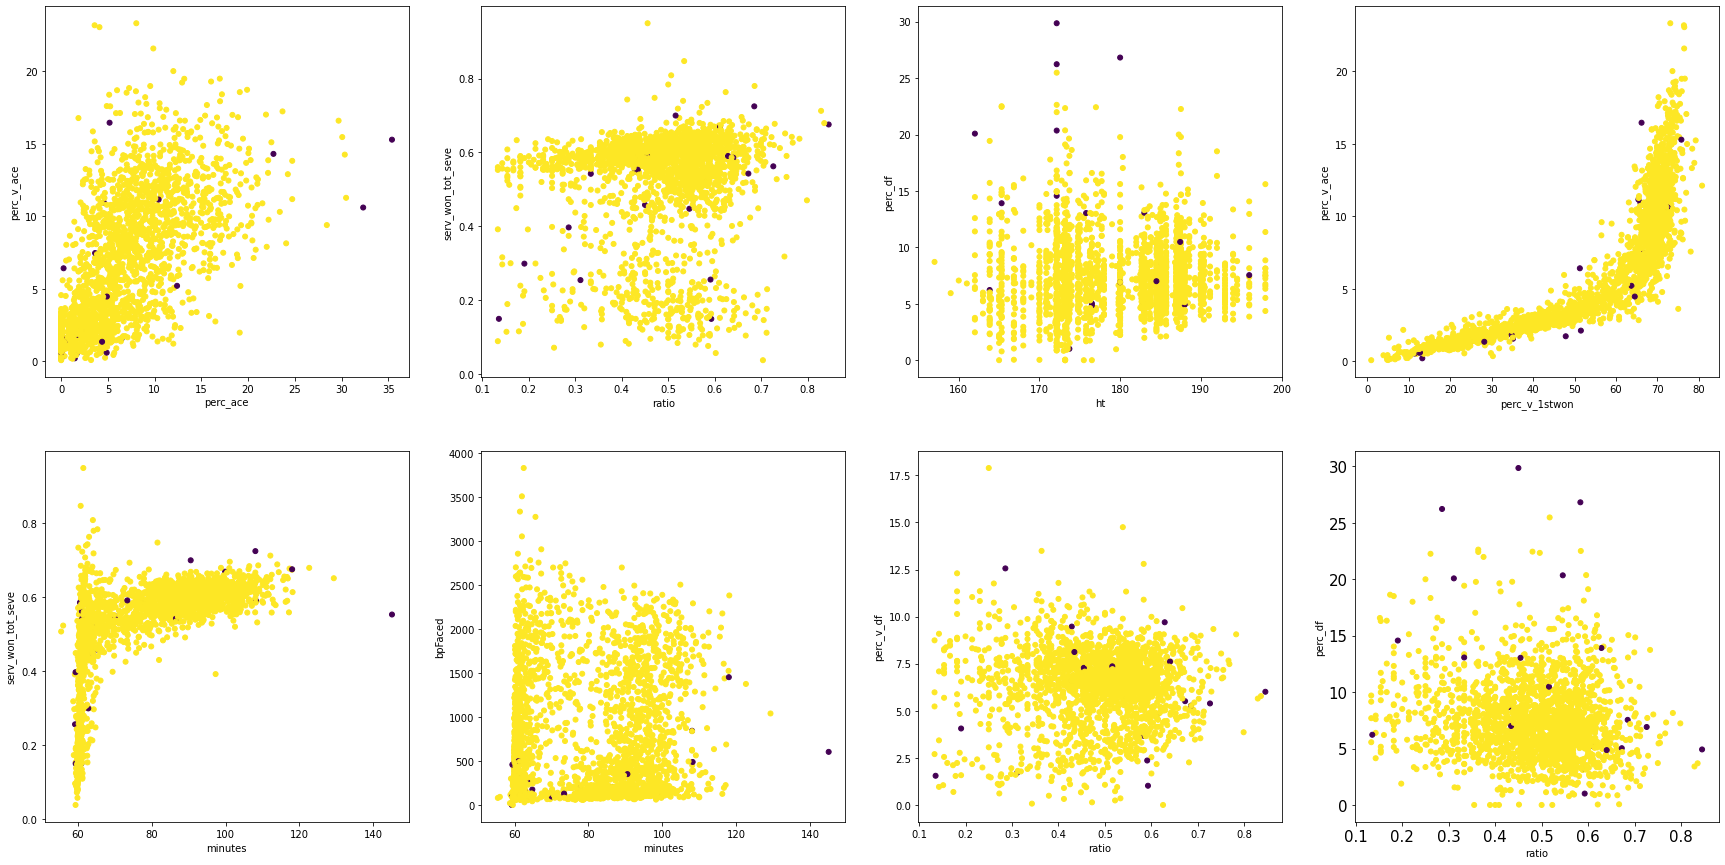

In [29]:
f, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30,15))
best_db = db_best_k[-1][0]
scatter_subplots(axs[0][0], num_features.perc_ace, num_features.perc_v_ace, 'perc_ace', 'perc_v_ace', best_db)
scatter_subplots(axs[0][1], num_features.ratio, num_features.serv_won_tot_seve, 'ratio', 'serv_won_tot_seve', best_db)
scatter_subplots(axs[0][2], num_features.ht, num_features.perc_df, 'ht', 'perc_df', best_db)
scatter_subplots(axs[0][3], num_features.perc_v_1stwon, num_features.perc_v_ace, 'perc_v_1stwon', 'perc_v_ace', best_db)

scatter_subplots(axs[1][0], num_features.minutes, num_features.serv_won_tot_seve, 'minutes', 'serv_won_tot_seve', best_db)
scatter_subplots(axs[1][1], df.minutes, num_features.bpFaced, 'minutes', 'bpFaced', best_db)
scatter_subplots(axs[1][2], num_features.ratio, num_features.perc_v_df, 'ratio', 'perc_v_df', best_db)
scatter_subplots(axs[1][3], num_features.ratio, num_features.perc_df, 'ratio', 'perc_df', best_db)


### X-MEANS (extra)

In [111]:
from pyclustering.cluster.silhouette import silhouette

In [65]:
scaled = np.array(scaled)

In [117]:
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(scaled, amount_initial_centers).initialize()
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 10.
xmeans_instance = xmeans(scaled, initial_centers, 10)
xmeans_instance.process()
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()


In [118]:
score = silhouette(scaled, clusters).process().get_score()
score

[0.4631163479796435,
 0.23290632622927931,
 0.0807601889981179,
 0.29144019582621994,
 0.16829720913900098,
 0.27282972925621063,
 0.49562313997895374,
 0.07544989069552531,
 0.18991527087116317,
 0.13861233703738424,
 0.42147051888963866,
 0.4620232118035283,
 0.060042764592507125,
 0.3084886503956521,
 0.26702456569270727,
 0.13635091451434864,
 0.32628000682308456,
 0.016029377937387377,
 0.37744203484214733,
 0.14214055799424977,
 0.058122027940594664,
 0.0634571022189635,
 0.3645474151755169,
 0.03238087330471816,
 0.05061110864405252,
 0.3690293197456671,
 0.11355763050748807,
 0.2910577077894556,
 0.1914275590330444,
 0.3113110064695396,
 0.1755425884907318,
 0.3165959956319152,
 0.19529628324384815,
 0.44596808379074254,
 0.16156633037391524,
 0.4144325624606169,
 0.39531960278084055,
 0.09458119000736645,
 0.20395077926518962,
 0.312379667954032,
 0.27004504462550355,
 0.20224215300001644,
 0.2511172356877673,
 0.10812975618715898,
 0.3387298488593704,
 0.2240296805894233,
 0.

In [119]:
ratio = scaled[:,0]
perc_ace = scaled[:,7]

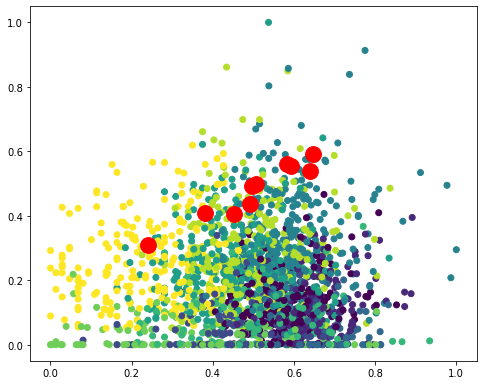

In [120]:
z_xm = np.ones(scaled.shape[0])
for k in range(len(xmeans_instance._xmeans__clusters)):
    z_xm[xmeans_instance._xmeans__clusters[k]] = k+1
plt.figure(figsize=(8,30))
plt.subplot(4, 1, 2)
plt.scatter(ratio, perc_ace, c=z_xm)
centers = np.array(xmeans_instance._xmeans__centers)
plt.scatter(centers[:,0],centers[:,1],s=250, marker='o',c='red')
plt.show()